In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import os,sys, gc
import matplotlib.pyplot as plt
sys.path.append("/content/drive/My Drive/phd")
sys.path.append("/content/drive/My Drive/phd/hsbm-occam")
!pip install -i https://test.pypi.org/simple/ -U topicpy
from topicpy.hsbmpy import get_max_available_L

os.environ["TF_CUDNN_USE_AUTOTUNE"]="0" #to avoid Nvidia GPU warming up

Looking in indexes: https://test.pypi.org/simple/
     |████████████████████████████████| 51kB 2.6MB/s 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
algorithm = "lda"
directory='/content/drive/My Drive/phd/datasets/gtex/all_samples'
L = get_max_available_L(directory, algorithm)
os.chdir(directory)

In [5]:
label = 'primary_site'

df_topics = pd.read_csv("%s/%s_level_%d_topic-dist.csv"%(algorithm,algorithm,L)).set_index('doc').drop('i_doc', axis=1)
df_words = pd.read_csv("%s/%s_level_%d_word-dist.csv"%(algorithm,algorithm,L), index_col=0)
df_words.index=[g[:15] for g in df_words.index]
df = pd.read_csv("mainTable.csv", index_col=0).reindex(index=df_words.index)
df = df.divide(df.sum(0),1).transpose().fillna(0)
df_files=pd.read_csv("files.dat", index_col=0)
df_topics.insert(0,'tissue', df_files.reindex(index=df_topics.index)[label])
df_topic_tissue = df_topics.groupby('tissue').mean()
print(df_files.head(2))
print(df_topics.head(2))

                            primary_site          secondary_site
_c0                                                             
GTEX-1117F-0226-SM-5GZZ7  Adipose Tissue  Adipose - Subcutaneous
GTEX-111CU-1826-SM-5GZYN  Adipose Tissue  Adipose - Subcutaneous
                                  tissue   Topic 1  ...  Topic 49  Topic 50
doc                                                 ...                    
GTEX-1117F-0226-SM-5GZZ7  Adipose Tissue  0.000383  ...  0.002912  0.012274
GTEX-111CU-1826-SM-5GZYN  Adipose Tissue  0.000232  ...  0.002832  0.001925

[2 rows x 51 columns]


## Predictor

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import binary_crossentropy,mean_squared_error, categorical_crossentropy
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model,to_categorical
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from tensorflow.python.client.device_lib import list_local_devices
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import os,sys, gc
list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12453618236165348714, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1638753417944384927
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 12476052513571260649
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11146722048
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2848648456339655701
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [7]:
df_labels=df_files.copy()
df_labels=df_labels.reindex(index=df_topics.index)

uniq = len(df_labels[label].unique())

X_train = df_topics.drop('tissue',1)
X_train = X_train.subtract(X_train.mean(0),1).divide(0.5*(X_train.max(0)-X_train.min(0)),1).values.astype(float) #SGD transform
Y_train = to_categorical(np.unique(df_labels[label], return_inverse=True)[1])
inputs = X_train.shape[1]

activation_func = "softmax"
lr = 0.03
bs = 100
hidden = 50
momentum = 0.95
l1 = 0.001
l2 = 1e-3
loss=categorical_crossentropy


classes=np.unique(df_labels[df_labels.index.isin(df.index)][label], return_inverse=True)[0]

X_tm_train, X_tm_test, Y_tm_train, Y_tm_test = train_test_split(X_train, Y_train, random_state=42, train_size=0.95)

print(uniq, X_train.shape, Y_train.shape, X_tm_train.shape, Y_tm_train.shape)

30 (11688, 50) (11688, 30) (11103, 50) (11103, 30)


# projections

In [8]:
import tensorflow as tf
from sklearn.metrics import accuracy_score, roc_auc_score

class ProjectorClassifier():
    def __init__(self):
        self.labels = None
        self._isfitted = False
        self._entropy = tf.keras.losses.KLDivergence()
        #self._entropy = tf.keras.losses.MeanSquaredError()
    
    def fit(self, X, Y):
        classes, _ = tf.unique(Y)
        self.labels = tf.map_fn(lambda c: tf.reduce_mean(tf.boolean_mask(X,tf.equal(Y, tf.repeat(c, tf.constant(Y.shape[0], dtype=tf.int64)))), axis=0), classes, dtype=tf.float64)
        self._isfitted = True

    def predict(self, X):
        if not self._isfitted:
            raise ValueError("Call Projector.fit() first")
        predictions = tf.argmin(tf.map_fn(lambda label: tf.map_fn(lambda x: self._entropy(x, label), X), self.labels), axis=0)
        return predictions

    def evaluate(self, X, Y):
        if not self._isfitted:
            raise ValueError("Call Projector.fit() first")
        Y_pred = self.predict(X)
        if tf.reduce_max(Y) > tf.constant(1, dtype=tf.int64):
            Y = to_categorical(Y)
            Y_pred = to_categorical(Y_pred)
        acc = accuracy_score(Y, Y_pred)
        auc = roc_auc_score(Y, Y_pred, average="weighted", multi_class="ovr")
        print(f"Accuracy: {acc}, AUC:{auc}")
        return [acc, auc]

In [9]:
X = tf.convert_to_tensor(df_topics.drop('tissue',1))
Y = tf.convert_to_tensor(Y_train)

X_pj_train, X_pj_test, Y_pj_train, Y_pj_test = train_test_split(X.numpy(), Y.numpy(), random_state=42, train_size=0.8)
Y_pj_train = tf.argmax(Y_pj_train, 1)
Y_pj_test = tf.argmax(Y_pj_test, 1)

#X_pj_train, X_pj_test, Y_pj_train, Y_pj_test = train_test_split(df.values, np.unique(df_files.reindex(index=df.index)[label], return_inverse=True)[1], random_state=42, train_size=0.8)
#X_pj_train, X_pj_test, Y_pj_train, Y_pj_test = train_test_split(pd.read_csv("mainTable.csv", index_col=0).reindex(index=df_words.index).fillna(0).applymap(lambda tpm: np.log2(tpm+1)).values.T, np.unique(df_files.reindex(index=df.index)[label], return_inverse=True)[1], random_state=42, train_size=0.8)

X_pj_train, X_pj_test, Y_pj_train, Y_pj_test = list(map(tf.convert_to_tensor, (X_pj_train, X_pj_test, Y_pj_train, Y_pj_test)))
print(uniq, X_pj_train.shape, Y_pj_train.shape, X_pj_test.shape, Y_pj_test.shape, Y_pj_train[0])

import time

with tf.device("GPU"):
    model_proj = ProjectorClassifier()
    model_proj.fit(X_pj_train, Y_pj_train)
    model_proj.evaluate(X_pj_test, Y_pj_test)

30 (9350, 50) (9350,) (2338, 50) (2338,) tf.Tensor(11, shape=(), dtype=int64)
Accuracy: 0.08212147134302823, AUC:0.522656359107845


# K-NN

In [10]:
from sklearn.neighbors import KNeighborsClassifier

class KNNClassifier(KNeighborsClassifier):
    def __init__(self, n_neighbors=10, **kwargs):
        super().__init__(n_neighbors, **kwargs)

    def fit(self,  X, y):
        return super().fit(X, y)

    def evaluate(self, X, Y):
        Y_pred = self.predict(X)
        if tf.reduce_max(Y) > tf.constant(1, dtype=tf.int64):
            Y = to_categorical(Y)
            Y_pred = to_categorical(Y_pred)
        acc = accuracy_score(Y, Y_pred)
        auc = roc_auc_score(Y, Y_pred, average="weighted", multi_class="ovr")
        print(f"Accuracy: {acc}, AUC:{auc}")
        return [acc, auc]

    
X_knn_train, X_knn_test, Y_knn_train, Y_knn_test = train_test_split(X.numpy(), Y.numpy(), random_state=42, train_size=0.8)
Y_knn_train = tf.argmax(Y_knn_train, 1)
Y_knn_test = tf.argmax(Y_knn_test, 1)

#X_knn_train, X_knn_test, Y_knn_train, Y_knn_test = train_test_split(df.values, np.unique(df_files.reindex(index=df.index)[label], return_inverse=True)[1], random_state=42, train_size=0.8)
#X_knn_train, X_knn_test, Y_knn_train, Y_knn_test = train_test_split(pd.read_csv("mainTable.csv", index_col=0).reindex(index=df_words.index).fillna(0).applymap(lambda tpm: np.log2(tpm+1)).values.T, np.unique(df_files.reindex(index=df.index)[label], return_inverse=True)[1], random_state=42, train_size=0.8)

X_pj_train, X_pj_test, Y_pj_train, Y_pj_test = list(map(tf.convert_to_tensor, (X_knn_train, X_knn_test, Y_knn_train, Y_knn_test)))
print(uniq, X_knn_train.shape, Y_knn_train.shape, X_knn_test.shape, Y_knn_test.shape, Y_knn_train[0])
import time
with tf.device("GPU"):
    model_knn = KNNClassifier(n_neighbors=5, n_jobs=4, metric="euclidean")
    model_knn.fit(X_knn_train, Y_knn_train)
    model_knn.evaluate(X_knn_test, Y_knn_test)

30 (9350, 50) (9350,) (2338, 50) (2338,) tf.Tensor(11, shape=(), dtype=int64)
Accuracy: 0.8926432848588537, AUC:0.9424093761134661


# Neural Net

In [11]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [12]:
def create_model(opt, l1=0.001, l2=1e-4, hidden=100, loss=categorical_crossentropy, activation_func = "softmax",  verbose=True):
    global X_tm_train
    global X_tm_test
    global Y_tm_train
    global Y_tm_test
    
    K.clear_session()

    os.system("rm -rf log.csv")
    csv_logger = CSVLogger('log.csv', append=True, separator=',')
    es = EarlyStopping(monitor='val_loss', min_delta=1e-10, mode='min', patience=25)

    model=Sequential()
    model.add(Dense(units=hidden, input_dim=inputs, use_bias=True, bias_initializer="ones", activation="relu", kernel_regularizer=l1_l2(l1=l1, l2=l2)))
    model.add(Dense(units=uniq, activation=activation_func))
    model.compile(loss=loss, optimizer=SGD(lr=lr, momentum=momentum), metrics=['accuracy', 'AUC', f1])
    K.set_learning_phase(0)

    print(model.summary())
    plot_model(model, to_file=f"model_{label}.png", dpi=600, show_shapes=True)
    return model, X_tm_train, X_tm_test, Y_tm_train, Y_tm_test 

In [13]:
def train_GS():
  csv_logger = CSVLogger('log.csv', append=True, separator=',')
  es = EarlyStopping(monitor='val_loss', min_delta=1e-3, mode='min', patience=25)

  momentum = 0.95
  best_model = None
  best_score = -np.inf
  for lr in [0.03, 0.01]:
    for l1 in np.logspace(-2,-4,3):
      for l2 in np.logspace(-3,-5,3):
        for bs in [10, 50, 100]:
          for momentum in [0.95, 0.98]:
            for hidden in [50, 75]:
              print(lr, l1, l2, bs, momentum, hidden)
              opt = SGD(lr=lr, momentum=momentum)
              model, X_train, X_test, Y_train, Y_test  = create_model(opt, l1, l2, hidden, verbose=False)
              with tf.device("GPU"):
                hist = model.fit(X_train, Y_train, epochs=500, batch_size=bs, verbose=0, validation_split=0.8, callbacks=[csv_logger, es], shuffle=True, use_multiprocessing=True, workers=-1)
              f1_score = hist.history["val_f1"][-1]
              if f1_score > best_score:
                loss = hist.history["val_loss"][-1]
                acc = hist.history["val_accuracy"][-1]
                auc = hist.history["val_auc"][-1]
                print(f"loss: {loss}, accuracy: {acc}, AUC: {auc}, f1: {f1_score}")
                best_score = f1_score
                best_model=model
  return best_model, lr, l1, l2, bs, momentum, hidden

#model, lr, l1, l2, bs, momentum, hidden = train_GS()
model, X_train, X_test, Y_train, Y_test  = create_model(SGD(lr=0.03, momentum=0.98), 0.001, 0.001, 50, verbose=False)

print(lr, l1, l2, bs, momentum, hidden)

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                2550      
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1530      
Total params: 4,080
Trainable params: 4,080
Non-trainable params: 0
_________________________________________________________________
None
0.03 0.001 0.001 100 0.95 50


In [14]:
with tf.device("GPU"):
    model.fit(X_train, Y_train, epochs=500, batch_size=50, validation_split=0.8, shuffle=True, use_multiprocessing=True, workers=-1)

Epoch 1/500
45/45 [==============================] - 2s 36ms/step - loss: 3.0239 - accuracy: 0.2802 - auc: 0.8079 - f1: 0.0596 - val_loss: 2.1524 - val_accuracy: 0.6001 - val_auc: 0.9247 - val_f1: 0.3110
Epoch 2/500
45/45 [==============================] - 1s 28ms/step - loss: 1.7397 - accuracy: 0.6712 - auc: 0.9626 - f1: 0.5110 - val_loss: 1.4243 - val_accuracy: 0.7376 - val_auc: 0.9764 - val_f1: 0.6563
Epoch 3/500
45/45 [==============================] - 1s 27ms/step - loss: 1.3292 - accuracy: 0.7477 - auc: 0.9815 - f1: 0.6981 - val_loss: 1.2504 - val_accuracy: 0.7696 - val_auc: 0.9860 - val_f1: 0.7289
Epoch 4/500
45/45 [==============================] - 1s 27ms/step - loss: 1.1613 - accuracy: 0.7905 - auc: 0.9884 - f1: 0.7449 - val_loss: 1.0937 - val_accuracy: 0.7825 - val_auc: 0.9894 - val_f1: 0.7671
Epoch 5/500
45/45 [==============================] - 1s 28ms/step - loss: 1.0629 - accuracy: 0.8036 - auc: 0.9912 - f1: 0.7803 - val_loss: 1.0291 - val_accuracy: 0.8275 - val_auc: 0.99

In [15]:
pd.read_csv("log.csv", sep=",")[['loss','val_loss']].plot()

FileNotFoundError: ignored

In [16]:
model.evaluate(X_tm_test, Y_tm_test)

19/19 [==============================] - 0s 5ms/step - loss: 0.5616 - accuracy: 0.8803 - auc: 0.9929 - f1: 0.8840


[0.5615984797477722,
 0.8803418874740601,
 0.9928805828094482,
 0.8839557766914368]

In [ ]:
model.save(f"model_{label}.h5")
#model = load_model(f"model_{label}.h5")
#print(model.summary())
#plot_model(model, to_file=f"model_{label}.png", dpi=600, show_shapes=True)

In [ ]:
gc.collect()

# evaluate on non used on topsbm training


In [24]:
df_test_table = pd.read_csv("../../merged/mainTable_test.csv", index_col = 0)
df_test_table = df_test_table.where(df_test_table<1e5,1e5)

In [26]:
#get only HV genes
df_topic_test = df_test_table.reindex(index=df_words.index)
df_topic_test = df_topic_test.transpose().fillna(-1).astype(int)

df_topic_test = pd.DataFrame(data=np.matmul(df_topic_test.values,df_words.values), index=df_topic_test.index, columns=df_words.columns)
df_test=df_topic_test.divide(df_topic_test.mean(axis=0), axis=1) #normalize P(t|d)

df_test = df_test.subtract(df_topics.drop("tissue",1).mean(0),1).divide((X_train.max(0)-X_train.min(0)),1) #SGD transform

In [31]:
#classes = np.unique(df_files.reindex(index=df_test.index)[label])
#X_test = df_test.values.astype(float)
#Y_test = to_categorical([np.where(classes==t)[0] for t in df_files.reindex(index=df_test.index)[label].values.ravel()])

X_test = X_tm_test
Y_test = Y_tm_test

#np.savetxt("classes.txt", classes, fmt="%s")
#np.savetxt("X_test.txt", X_test)
#np.savetxt("Y_test.txt", Y_test)

In [18]:
with tf.device("GPU"):
    model.evaluate(X_test, Y_test, verbose=2, workers=-1, use_multiprocessing=True)

19/19 - 0s - loss: 0.5616 - accuracy: 0.8803 - auc: 0.9929 - f1: 0.8840


In [19]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns

In [20]:
y_pred_p = model.predict(X_test)
if uniq>1:
  y_true = np.argmax(Y_test,axis=-1)
  y_pred = np.argmax(y_pred_p,axis=-1)
else:
  y_pred_p = y_pred_p.ravel()
  y_true = Y_test
  y_pred = np.ones(y_pred_p.shape)
  y_pred[y_pred_p<0.5]=0
results = confusion_matrix(y_true, y_pred, normalize="true")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


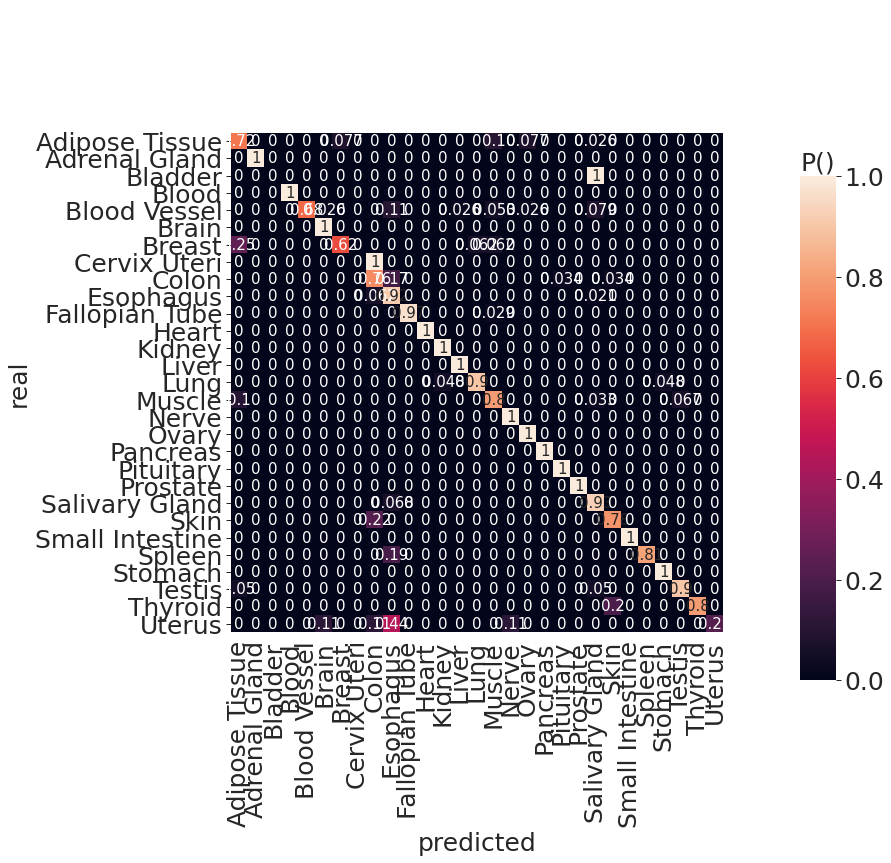

In [21]:
plt.rcParams["figure.figsize"] = (45,45)

cm = sns.clustermap(results, 
                    vmax=1,  
                    row_cluster=False, 
                    col_cluster=False, 
                    xticklabels=classes, 
                    yticklabels=classes, 
                    annot=False,
                    annot_kws={"fontsize":15},
                    cbar_pos=(0.99,0.05,0.05,0.7))
ax = cm.ax_heatmap
fig = ax.get_figure()
ax.set_ylabel("real", fontsize=25, rotation=90)
ax.set_yticklabels(labels=classes, rotation=0)
ax.yaxis.tick_left()
ax.yaxis.set_label_position("left")

ax.set_xticklabels(labels=classes, rotation=90)
ax.set_xlabel("predicted",fontsize=25)
ax.tick_params(labelsize=25)

cax = cm.ax_cbar
cax.tick_params(labelsize=25)
cax.set_title("P()", fontsize=25)
plt.tight_layout()
cm.savefig(f"predict_{label}.pdf")

plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


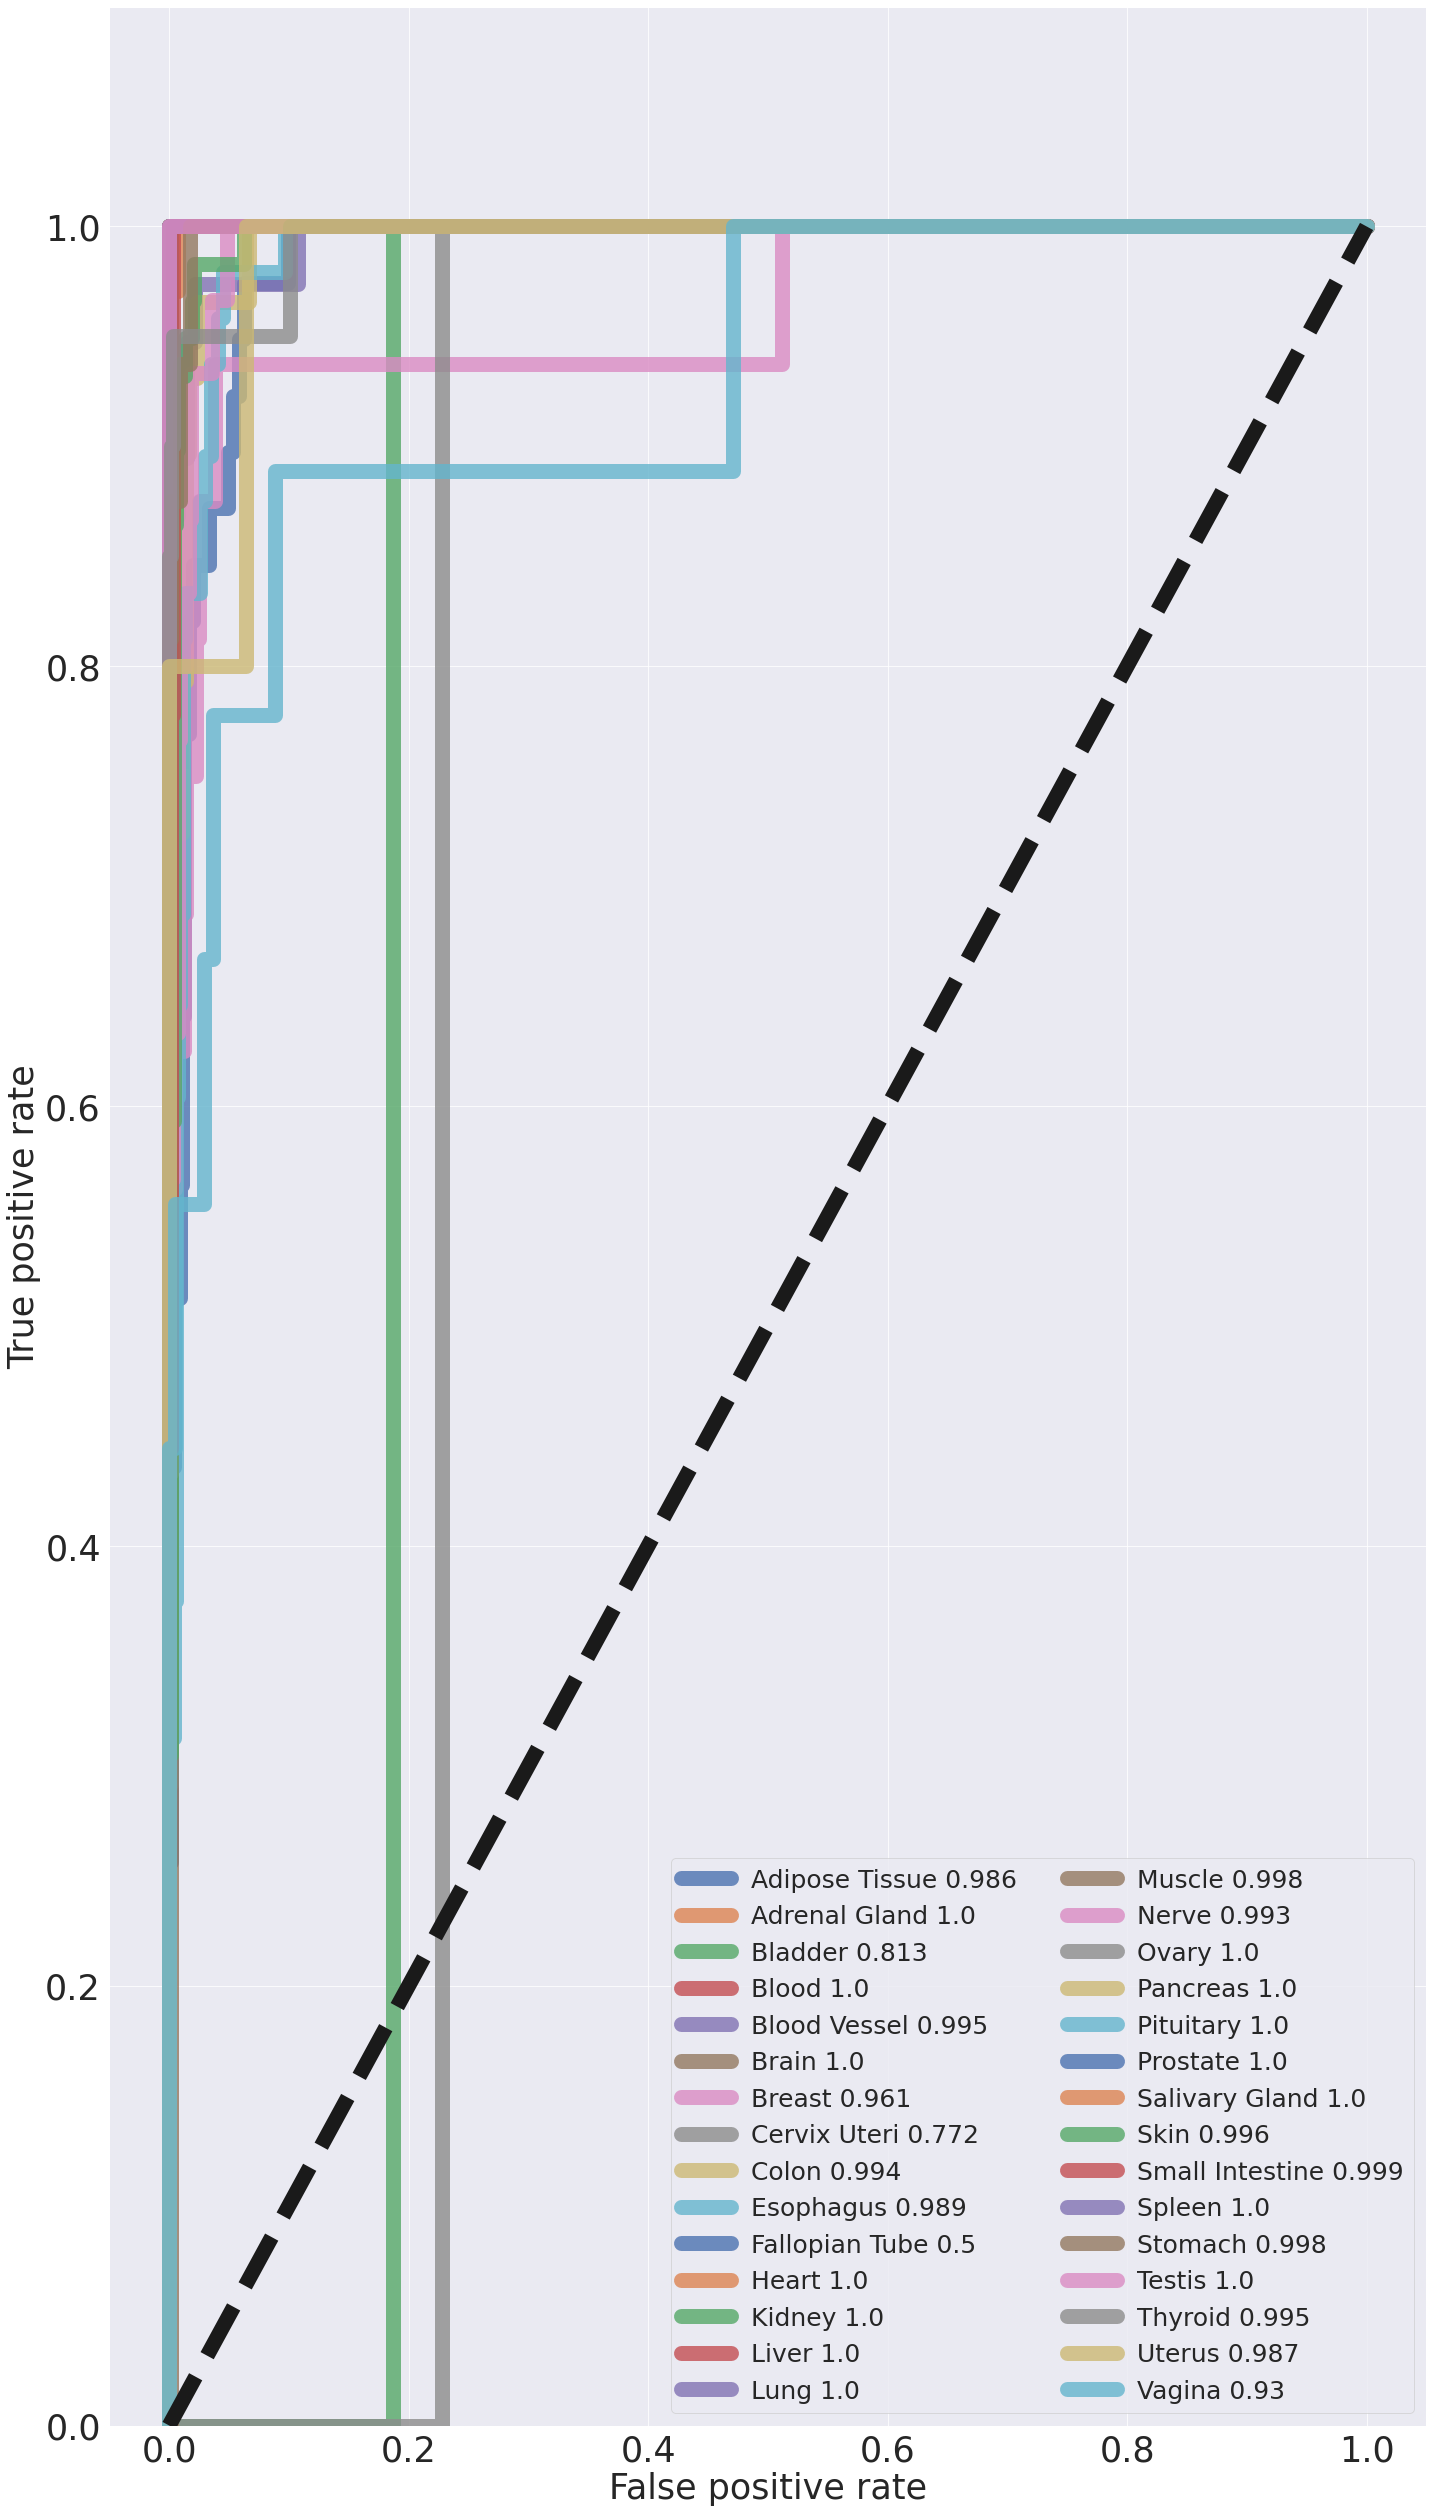

In [40]:
fig, ax = plt.subplots(figsize=(20,35))
for itissue, tissue in enumerate(classes):
  tissue_true = y_true.copy()
  tissue_true[y_true==itissue]=1
  tissue_true[y_true!=itissue]=0
  fpr, tpr, thresholds = roc_curve(tissue_true, y_pred_p.T[itissue])

  try:
    score = round(roc_auc_score(tissue_true, y_pred_p.T[itissue]),3)
  except:
    score = 0.5
  ax.plot(fpr,tpr, lw=15, alpha=0.8, label = f"{tissue} {score}")

ax.plot([0, 1], [0, 1], 'k--', lw=15)
ax.set_xlabel('False positive rate', fontsize=35)
ax.set_ylabel('True positive rate', fontsize=35)

ax.tick_params(labelsize=35)

ax.set_ylim(0,1.1)
ax.legend(ncol=2, fontsize=25)
plt.tight_layout()
plt.show()
fig.savefig(f"roc_{label}.pdf")